# Exercise 02: Multi-class Classification 
In this exercise, you will train a deep model on the CIFAR10 from the scratch using PyTorch. The following tasks should be done:
- Task 1: per batch training/testing
- Task 2: Instance inference and visualization

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision
import torchvision.models as models

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm
import time

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#随机裁剪并进行边缘填充，随机翻转，转换为张量，图像规范化
#transforms.Compose可以进行多个数据转换操作

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#测试不需要对图像进行处理


train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = models.resnet50(pretrained= True)
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(
    nn.Linear(2048, 32), 
    nn.ReLU(),
    nn.Linear(32, 10)  
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
#model = ConvNet()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Optimizer

In [7]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [8]:
##################### Write your answer here ##################
# Define the loss function
criterion = nn.CrossEntropyLoss(reduction='mean')
###############################################################

In [9]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

In [10]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

### Model Training

In [11]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1/30 Train Loss: 0.0154 Acc: 0.2887
Begin test......


  3%|▎         | 1/30 [00:11<05:23, 11.16s/it]

Test Loss: 0.0160 Acc: 0.2980
Epoch: 2/30 Train Loss: 0.0148 Acc: 0.3339
Begin test......


  7%|▋         | 2/30 [00:21<05:03, 10.83s/it]

Test Loss: 0.0152 Acc: 0.3238
Epoch: 3/30 Train Loss: 0.0144 Acc: 0.3545
Begin test......


 10%|█         | 3/30 [00:32<04:48, 10.70s/it]

Test Loss: 0.0151 Acc: 0.3381
Epoch: 4/30 Train Loss: 0.0145 Acc: 0.3525
Begin test......


 13%|█▎        | 4/30 [00:42<04:36, 10.65s/it]

Test Loss: 0.0153 Acc: 0.3340
Epoch: 5/30 Train Loss: 0.0145 Acc: 0.3513
Begin test......


 17%|█▋        | 5/30 [00:53<04:25, 10.61s/it]

Test Loss: 0.0156 Acc: 0.3179
Epoch: 6/30 Train Loss: 0.0134 Acc: 0.3974
Begin test......


 20%|██        | 6/30 [01:03<04:14, 10.59s/it]

Test Loss: 0.0138 Acc: 0.3872
Epoch: 7/30 Train Loss: 0.0130 Acc: 0.4135
Begin test......


 23%|██▎       | 7/30 [01:14<04:03, 10.57s/it]

Test Loss: 0.0137 Acc: 0.4007
Epoch: 8/30 Train Loss: 0.0130 Acc: 0.4201
Begin test......


 27%|██▋       | 8/30 [01:25<03:52, 10.56s/it]

Test Loss: 0.0136 Acc: 0.4062
Epoch: 9/30 Train Loss: 0.0129 Acc: 0.4237
Begin test......


 30%|███       | 9/30 [01:35<03:41, 10.56s/it]

Test Loss: 0.0136 Acc: 0.3975
Epoch: 10/30 Train Loss: 0.0129 Acc: 0.4218
Begin test......


 33%|███▎      | 10/30 [01:46<03:31, 10.58s/it]

Test Loss: 0.0135 Acc: 0.4115
Epoch: 11/30 Train Loss: 0.0123 Acc: 0.4495
Begin test......


 37%|███▋      | 11/30 [01:56<03:20, 10.56s/it]

Test Loss: 0.0126 Acc: 0.4442
Epoch: 12/30 Train Loss: 0.0122 Acc: 0.4491
Begin test......


 40%|████      | 12/30 [02:07<03:09, 10.55s/it]

Test Loss: 0.0128 Acc: 0.4425
Epoch: 13/30 Train Loss: 0.0122 Acc: 0.4494
Begin test......


 43%|████▎     | 13/30 [02:17<02:59, 10.55s/it]

Test Loss: 0.0131 Acc: 0.4471
Epoch: 14/30 Train Loss: 0.0121 Acc: 0.4521
Begin test......


 47%|████▋     | 14/30 [02:28<02:49, 10.58s/it]

Test Loss: 0.0128 Acc: 0.4416
Epoch: 15/30 Train Loss: 0.0121 Acc: 0.4554
Begin test......


 50%|█████     | 15/30 [02:39<02:38, 10.58s/it]

Test Loss: 0.0128 Acc: 0.4474
Epoch: 16/30 Train Loss: 0.0119 Acc: 0.4652
Begin test......


 53%|█████▎    | 16/30 [02:49<02:28, 10.58s/it]

Test Loss: 0.0123 Acc: 0.4546
Epoch: 17/30 Train Loss: 0.0118 Acc: 0.4665
Begin test......


 57%|█████▋    | 17/30 [03:00<02:17, 10.57s/it]

Test Loss: 0.0124 Acc: 0.4455
Epoch: 18/30 Train Loss: 0.0118 Acc: 0.4664
Begin test......


 60%|██████    | 18/30 [03:10<02:06, 10.56s/it]

Test Loss: 0.0127 Acc: 0.4439
Epoch: 19/30 Train Loss: 0.0118 Acc: 0.4671
Begin test......


 63%|██████▎   | 19/30 [03:21<01:56, 10.56s/it]

Test Loss: 0.0126 Acc: 0.4625
Epoch: 20/30 Train Loss: 0.0118 Acc: 0.4686
Begin test......


 67%|██████▋   | 20/30 [03:31<01:45, 10.57s/it]

Test Loss: 0.0128 Acc: 0.4538
Epoch: 21/30 Train Loss: 0.0116 Acc: 0.4744
Begin test......


 70%|███████   | 21/30 [03:42<01:35, 10.58s/it]

Test Loss: 0.0125 Acc: 0.4561
Epoch: 22/30 Train Loss: 0.0116 Acc: 0.4799
Begin test......


 73%|███████▎  | 22/30 [03:53<01:24, 10.57s/it]

Test Loss: 0.0122 Acc: 0.4651
Epoch: 23/30 Train Loss: 0.0116 Acc: 0.4777
Begin test......


 77%|███████▋  | 23/30 [04:03<01:14, 10.58s/it]

Test Loss: 0.0122 Acc: 0.4700
Epoch: 24/30 Train Loss: 0.0115 Acc: 0.4786
Begin test......


 80%|████████  | 24/30 [04:14<01:03, 10.60s/it]

Test Loss: 0.0122 Acc: 0.4599
Epoch: 25/30 Train Loss: 0.0116 Acc: 0.4780
Begin test......


 83%|████████▎ | 25/30 [04:24<00:52, 10.60s/it]

Test Loss: 0.0121 Acc: 0.4708
Epoch: 26/30 Train Loss: 0.0114 Acc: 0.4852
Begin test......


 87%|████████▋ | 26/30 [04:35<00:42, 10.60s/it]

Test Loss: 0.0123 Acc: 0.4715
Epoch: 27/30 Train Loss: 0.0115 Acc: 0.4835
Begin test......


 90%|█████████ | 27/30 [04:45<00:31, 10.58s/it]

Test Loss: 0.0121 Acc: 0.4754
Epoch: 28/30 Train Loss: 0.0115 Acc: 0.4830
Begin test......


 93%|█████████▎| 28/30 [04:56<00:21, 10.58s/it]

Test Loss: 0.0123 Acc: 0.4564
Epoch: 29/30 Train Loss: 0.0115 Acc: 0.4812
Begin test......


 97%|█████████▋| 29/30 [05:07<00:10, 10.60s/it]

Test Loss: 0.0121 Acc: 0.4689
Epoch: 30/30 Train Loss: 0.0115 Acc: 0.4827
Begin test......
Test Loss: 0.0124 Acc: 0.4605


100%|██████████| 30/30 [05:18<00:00, 10.60s/it]


### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [12]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [13]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################

probabilities = F.softmax(model(image),dim=1)
predict_label = torch.argmax(probabilities,dim=1)    
print(predict_label)


tensor([4, 3, 8, 8, 8, 4, 7, 0, 3, 9, 5, 8, 7, 3, 1, 7], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


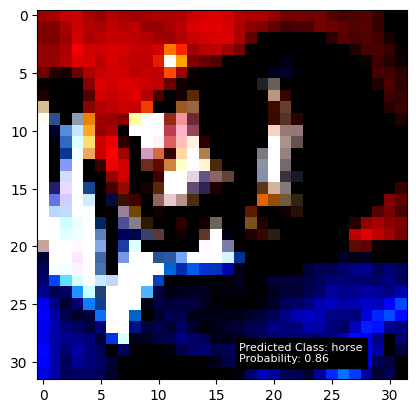

Print probabilities for each class:
airplane: 0.0036
automobile: 0.0034
bird: 0.0047
cat: 0.0251
deer: 0.0216
dog: 0.0669
frog: 0.0029
horse: 0.8604
ship: 0.0008
truck: 0.0106


In [14]:
for i in range(len(predict_label)):
    predicted_class = class_names[predict_label[i].item()]
    predicted_probability = probabilities[i][predict_label[i]].item()
    
image = input.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[15][i]:.4f}')